In [1]:
import os
import numpy as np
import keras
from keras import layers,models
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  90.4M      0  0:00:08  0:00:08 --:--:--  111M


In [3]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 CDLA-Permissive-2.0.pdf      PetImages        sample_data
 kagglecatsanddogs_5340.zip  'readme[1].txt'


In [4]:
!ls PetImages

Cat  Dog


deletando imagens corrompidas

In [5]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1

            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


In [6]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


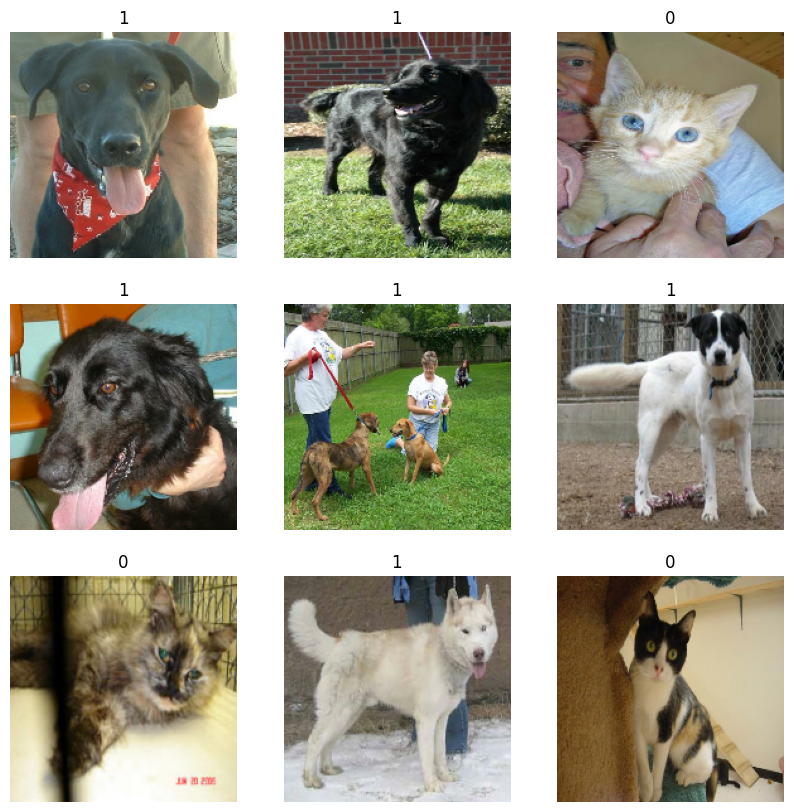

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


aumentando a base com imagens levemente modificadas, que mantém o proposito

In [8]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

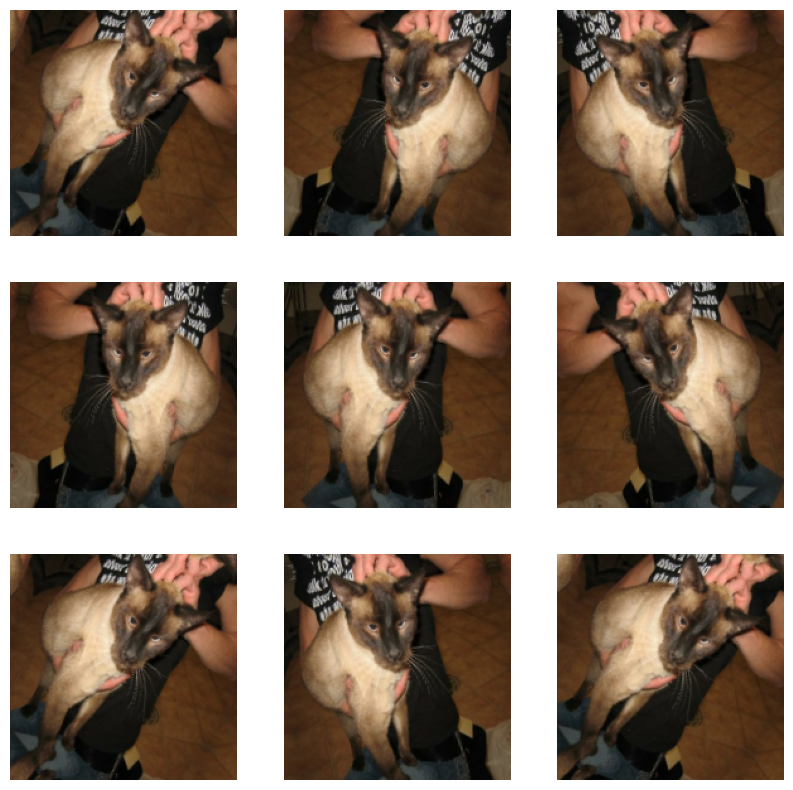

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [10]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)

train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [13]:
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(256, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(512, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

In [14]:
epochs = 25


model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
)

Epoch 1/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 146s 781ms/step - acc: 0.6123 - loss: 0.7663 - val_acc: 0.4957 - val_loss: 0.9411
Epoch 2/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 150s 613ms/step - acc: 0.6937 - loss: 0.6147 - val_acc: 0.5096 - val_loss: 0.8228
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 90s 605ms/step - acc: 0.7439 - loss: 0.5247 - val_acc: 0.5901 - val_loss: 0.8444
Epoch 4/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 142s 603ms/step - acc: 0.7771 - loss: 0.4781 - val_acc: 0.6713 - val_loss: 0.6096
Epoch 5/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 147s 634ms/step - acc: 0.8046 - loss: 0.4274 - val_acc: 0.7578 - val_loss: 0.5001
Epoch 6/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 138s 609ms/step - acc: 0.8295 - loss: 0.3813 - val_acc: 0.8076 - val_loss: 0.4097
Epoch 7/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 141s 604ms/step - acc: 0.8356 - loss: 0.3648 - val_acc: 0.8152 - val_loss: 0.4060
Epoch 8/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 143s 615ms/step - acc: 0.8544 - loss: 0.3398 - val_acc: 0.8830 - val_loss: 0.3037
Epoch 9/25
147/147 ━━━━━━

In [30]:
loss, acc = model.evaluate(val_ds)
print(f'Acurácia final na validação: {acc:.2f}')

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - acc: 0.9402 - loss: 0.1758
Acurácia final na validação: 0.93


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
This image is 96.25% cat and 3.75% dog.


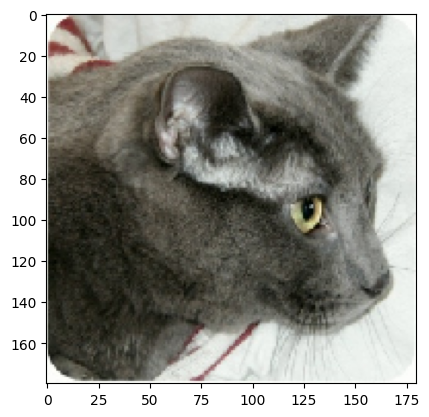

In [40]:
img = keras.utils.load_img("PetImages/Cat/6779.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
predictions = float(predictions[0][0])

print(f"This image is {100 * (1 - predictions):.2f}% cat and {100 * predictions:.2f}% dog.")

37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step


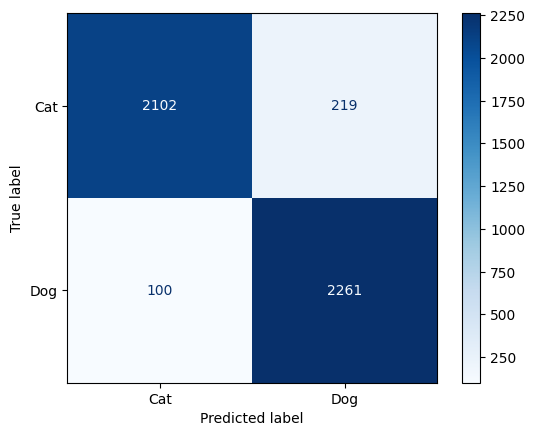

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


y_pred = model.predict(val_ds)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

y_true = np.concatenate([y for x, y in val_ds], axis=0)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cat', 'Dog'])
disp.plot(cmap='Blues')
plt.show()